# **Spit some [tensor] flow**

We need to learn the intricacies of tensorflow to master deep learning

`Let's get this over with`



## Look at the following equations 

Well now we're going to go into the details of the implementation; 

```
x_pred_t = w0 + w1 * x_t-1 + w2 * x_t-2 + w3 * x_t-3 + w4 * x_t-4

x_pred_t+1 = w0 + w1 * x_pred_t + w2 * x_t-1 + w3 * x_t-2 + w4 * x_t-3
```

This is an autoregressive model now. 

```
x_pred_5 = w0 + w1 * x_4 + w2 * x_3 + w3 * x_2 + w4 * x_1

x_pred_6 = w0 + w1 * x_pred_5 + w2 * x_4 + w3 * x_3 + w4 * x_2

```

We know that the predictions at time T in an RNN depend on all the previous times. Thus, indirectly, y(t) depends on x(t), x(t-1), x(t-2),....., x(2), x(1)

To optimize the weights, we must take the derivative of the equation containing the weights; however, there will be numerous W_input_to_hidden weights in the network. 


The RNN keeps nesting the older timestamps; the derivatives use multiplication and chain rule in composite functions, thus, the more older the timestamp, the more its gradient vanishes.

## So how do GRU's work?

Throwback to the RNN equation: 

h(t) = activation(W(x,h) x(t) + W(h,h) h(t-1) + b(h))

GRU's calulate two other things to calculate h(t):

- update gate vector z(t)

- reset gate vector r(t)

z(t) = sigmoid(W(x,z) x(t) + W(h,z) h(t-1) + b(z))

r(t) = sigmoid(W(x,r) x(t) + W(h,r) h(t-1) + b(r))

```
h(t) = (1 - z(t)) * h(t-1)  +

        z(t) tanh(W(x,h) x(t) + W(h,h) (r(t) * h(t-1)) + b(h))
```

(*) ==== element wise multiplication

z(t), r(t), h(t) ===== Size U

## Z(t) 

Should we take the new value of h(t)? or keep h(t-1)? 

- z(t) close to 0, take h(t-1)

- z(t) close to 1, take h(t)

So: 

```
h(t) = (1 - z(t)) * h(t-1)  +

        z(t) tanh(W(x,h) x(t) + W(h,h) (r(t) * h(t-1)) + b(h))
```

Becomes 

```
h(t) = (factor keep h(t-1)) * h(t-1) + 

       (discard h(t-1)) * RNN(x(t), h(t-1))
```

## R(t) 

Change the value of h(t-1) 

- r(t) close to 0, zero value h(t-1)

- r(t) close to 1, keep value h(t-1)


## So how do LSTM's work?

### https://towardsdatascience.com/

We add another state to the mix, the cell state c(t)

we add three different neurons:

forget neuron = f(t) 

This gate decides which information should be thrown away or kept. Input from h(t-1) and x(t) is passed through this gate; and it uses sigmoid to either forget (0) or remember (1) it.


input gate neuron = i(t)

We use this to update the cell state. We pass the h(t-1) and x(t) to the sigmoid function. This will decide which values will be updated in the cell state.

output gate neuron = o(t) 

The output gate decides what the next hidden state h(t) should be. Remember that the hidden state contains information on previous inputs. The hidden state is also used for predictions. 

First, we pass the previous hidden state and the current input into a sigmoid function.

Then we pass the newly modified cell state to the tanh function. 

We multiply the tanh output with the sigmoid output to decide what information the hidden state should carry. 

The output is the hidden state. 

The new cell state and the new hidden is then carried over to the next time step.

```

f(t) = sigmoid ( W(x,f) x(t) + W(h, f)h(t-1) + b(f) )

i(t) = sigmoid ( W(x,i) x(t) + W(h, i)h(t-1) + b(i) ) 

o(t) = sigmoid ( W(x,o) x(t) + W(h, o)h(t-1) + b(o) ) 


c(t) = f(t) * c(t-1) + 

       i(t) * tanh ( W(x,c) x(t) + W(h,c) h(t-1) + b(c) ) 


h(t) = o(t) * tanh( c(t) )

```




## In this notebook, we will check how the single step versus the multi step forecast can make it or break it in Deep learning

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
print(tf.__version__)

2.2.0


In [0]:
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, SimpleRNN, GRU, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, Adamax

In [0]:
def make_series(T, D, data):
  X = []
  y = []
  print(len(data))  
  print("The last sample would be: " + str(len(data)) + " - " + str(T) + " = " + str((len(data)-T)) )

  for i in range(len(data) - T):
    x = data[i:i+T]
    X.append(x)
    y_temp = data[i+T]
    y.append(y_temp)

  # Since we need an N x T x D input
  X = np.array(X).reshape(-1, T, D) 
  y = np.array(y)

  print(X.shape)
  print(y.shape)

  N, T, D = X.shape

  return N, T, D, X, y

## Let's get some synthetic data

In [0]:
# Importing the training set
dataset = pd.read_csv('sample_data/Google_Stock_Price_Train.csv')
data = dataset.iloc[:, 1:2].values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(data)


In [0]:
N, T, D, X, y = make_series(40, 1, data)

In [0]:
i_layer = Input(shape = (T, D))
h_layer = SimpleRNN(10)(i_layer)
o_layer = Dense(1)(h_layer)
model = Model(i_layer, o_layer)
model.compile(loss = 'mse',
              optimizer = Adam(lr = 0.1))

In [54]:
index = -N//4
report = model.fit(X[:index], y[:index], epochs=50, validation_data=(X[index:], y[index:]))

Epoch 1/50
29/29 [==============================] - 1s 36ms/step - loss: 0.0785 - val_loss: 0.2074
Epoch 2/50
29/29 [==============================] - 1s 34ms/step - loss: 0.0073 - val_loss: 0.0785
Epoch 3/50
29/29 [==============================] - 1s 33ms/step - loss: 0.0064 - val_loss: 0.1319
Epoch 4/50
29/29 [==============================] - 1s 33ms/step - loss: 0.0039 - val_loss: 0.0834
Epoch 5/50
29/29 [==============================] - 1s 35ms/step - loss: 0.0037 - val_loss: 0.0603
Epoch 6/50
29/29 [==============================] - 1s 34ms/step - loss: 0.0052 - val_loss: 0.1130
Epoch 7/50
29/29 [==============================] - 1s 34ms/step - loss: 0.0051 - val_loss: 0.0557
Epoch 8/50
29/29 [==============================] - 1s 32ms/step - loss: 0.0071 - val_loss: 0.0430
Epoch 9/50
29/29 [==============================] - 1s 34ms/step - loss: 0.0055 - val_loss: 0.0653
Epoch 10/50
29/29 [==============================] - 1s 33ms/step - loss: 0.0047 - val_loss: 0.0780
Epoch 11/

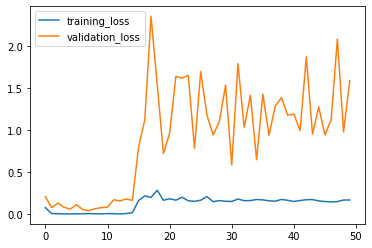

In [55]:
plt.plot(report.history['loss'], label='training_loss')
plt.plot(report.history['val_loss'], label='validation_loss')
plt.legend()

In [0]:
y_test = y[index:]
y_pred = []

In [0]:
X_end = X[index]
while len(y_pred) < len(y_test):
  pred = model.predict(X_end.reshape(1, -1))[0,0]
  y_pred.append(pred)
  X_end = np.roll(X_end, -1)
  X_end[-1] = pred

In [58]:
print(len(y_pred))
print(len(y_test))

300
300


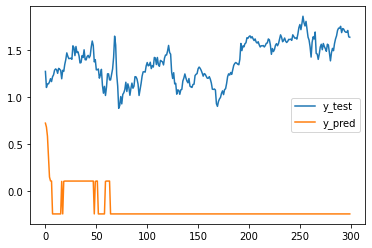

In [59]:
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()

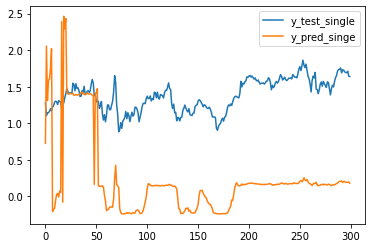

In [60]:
y_test_single = y[index:]
y_pred_single = []

i = index
while len(y_pred_single) < len(y_test_single):
  pred = model.predict(X[i].reshape(1,T, D))[0,0]
  i+=1
  y_pred_single.append(pred)

plt.plot(y_test_single, label='y_test_single')
plt.plot(y_pred_single, label='y_pred_singe')
plt.legend()

## This is bad, the single prediction shows that our model just does not learn anything, this is bad bad bad

But we're in too deep in the world of deep learning, we must find a way! Let's fix our window


1258
The last sample would be: 1258 - 10 = 1248
Epoch 1/60
33/33 [==============================] - 0s 11ms/step - loss: 0.0679 - val_loss: 0.0400
Epoch 2/60
33/33 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0232
Epoch 3/60
33/33 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0250
Epoch 4/60
33/33 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0108
Epoch 5/60
33/33 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0098
Epoch 6/60
33/33 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0142
Epoch 7/60
33/33 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0098
Epoch 8/60
33/33 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0083
Epoch 9/60
33/33 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0125
Epoch 10/60
33/33 [==============================] - 0s 4ms/step - lo

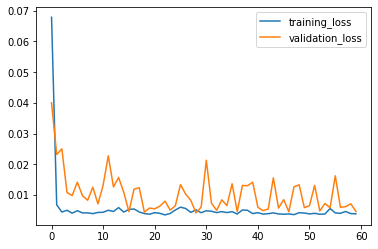

In [82]:
N, T, D, X, y = make_series(10, 1, data)

i_layer = Input(shape = (T, D))
h_layer = GRU(10, activation='tanh')(i_layer)
o_layer = Dense(1)(h_layer)
model = Model(i_layer, o_layer)
model.compile(loss = 'mse',
              optimizer = Adam(lr = 0.1))

index = -N//6
report = model.fit(X[:index], y[:index], epochs=60, validation_data=(X[index:], y[index:]))

plt.plot(report.history['loss'], label='training_loss')
plt.plot(report.history['val_loss'], label='validation_loss')
plt.legend()

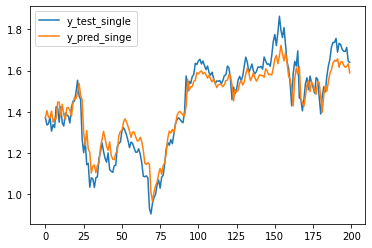

In [84]:
y_test_single = y[index:]
y_pred_single = []

i = index
while len(y_pred_single) < len(y_test_single):
  pred = model.predict(X[i].reshape(1,T, D))[0,0]
  i+=1
  y_pred_single.append(pred)

plt.plot(y_test_single, label='y_test_single')
plt.plot(y_pred_single, label='y_pred_singe')
plt.legend()

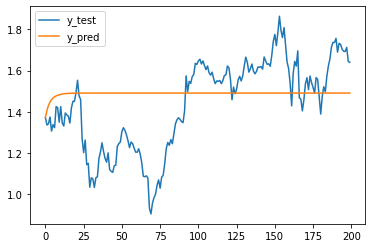

In [83]:
y_test = y[index:]
y_pred = []
X_end = X[index]
while len(y_pred) < len(y_test):
  pred = model.predict(X_end.reshape(1, -1))[0,0]
  y_pred.append(pred)
  X_end = np.roll(X_end, -1)
  X_end[-1] = pred
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()

## So the single versus multi-step has absolutely demolished the concept of an RNN for us :/ But wait a minute, how do people predict this? They predict the returns

In [0]:
# Importing the training set
dataset = pd.read_csv('sample_data/Google_Stock_Price_Train.csv', thousands= ',')
dataset['ShiftedClose'] = dataset['Close'].shift(1)


In [0]:
dataset['Return'] = (dataset['Close'] - dataset['ShiftedClose']) /  dataset['ShiftedClose']

In [162]:
dataset.head()

,Date,Open,High,Low,Close,Volume,ShiftedClose,Return
0,1/3/2012,325.25,332.83,324.97,663.59,7380500,NaN,NaN
1,1/4/2012,331.27,333.87,329.08,666.45,5749400,663.59,0.004310
2,1/5/2012,329.83,330.75,326.89,657.21,6590300,666.45,-0.013865
3,1/6/2012,328.34,328.77,323.68,648.24,5405900,657.21,-0.013649
4,1/9/2012,322.04,322.29,309.46,620.76,11688800,648.24,-0.042392


In [164]:
# Normalize 
from sklearn.preprocessing import StandardScaler
data = dataset.iloc[:, [-1]]
scaler = StandardScaler()
data = scaler.fit_transform(data)

data = data[1:]
data

array([[ 0.19146114],
       [-0.69526603],
       [-0.68473227],
       ...,
       [-0.41946791],
       [-0.1592743 ],
       [-0.70255865]])

In [165]:
N, T, D, X, y = make_series(60, 1, data)

1257
The last sample would be: 1257 - 60 = 1197
(1197, 60, 1)
(1197, 1)


Epoch 1/60
19/19 [==============================] - 0s 22ms/step - loss: 1.5137 - val_loss: 0.5625
Epoch 2/60
19/19 [==============================] - 0s 7ms/step - loss: 1.4894 - val_loss: 0.5607
Epoch 3/60
19/19 [==============================] - 0s 7ms/step - loss: 1.4842 - val_loss: 0.5601
Epoch 4/60
19/19 [==============================] - 0s 7ms/step - loss: 1.4845 - val_loss: 0.5610
Epoch 5/60
19/19 [==============================] - 0s 7ms/step - loss: 1.4806 - val_loss: 0.5618
Epoch 6/60
19/19 [==============================] - 0s 7ms/step - loss: 1.4819 - val_loss: 0.5660
Epoch 7/60
19/19 [==============================] - 0s 7ms/step - loss: 1.4807 - val_loss: 0.5657
Epoch 8/60
19/19 [==============================] - 0s 8ms/step - loss: 1.4803 - val_loss: 0.5694
Epoch 9/60
19/19 [==============================] - 0s 7ms/step - loss: 1.4748 - val_loss: 0.5713
Epoch 10/60
19/19 [==============================] - 0s 7ms/step - loss: 1.4779 - val_loss: 0.5716
Epoch 11/60
19/19 

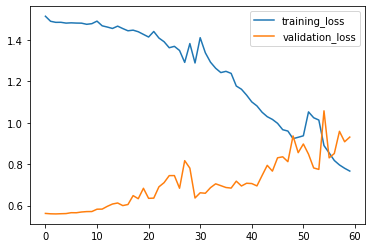

In [167]:
i_layer = Input(shape = (T, D))
h_layer = LSTM(10)(i_layer)
o_layer = Dense(1)(h_layer)
model = Model(i_layer, o_layer)
model.compile(loss = 'mse',
              optimizer = Adam(lr = 0.01))

index = -N//2
report = model.fit(X[:index], y[:index], epochs=60, validation_data=(X[index:], y[index:]))

plt.plot(report.history['loss'], label='training_loss')
plt.plot(report.history['val_loss'], label='validation_loss')
plt.legend()

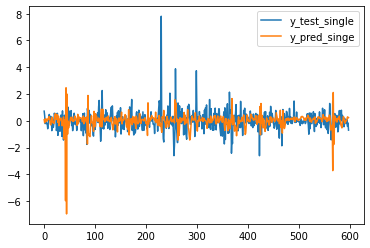

In [168]:

y_test_single = y[index:]
y_pred_single = []

i = index
while len(y_pred_single) < len(y_test_single):
  pred = model.predict(X[i].reshape(1,T, D))[0,0]
  i+=1
  y_pred_single.append(pred)

plt.plot(y_test_single, label='y_test_single')
plt.plot(y_pred_single, label='y_pred_singe')
plt.legend()

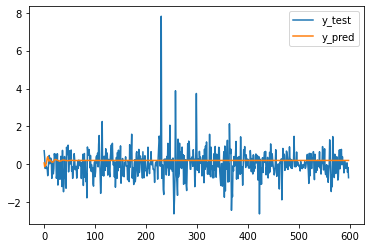

In [169]:
y_test = y[index:]
y_pred = []
X_end = X[index]
while len(y_pred) < len(y_test):
  pred = model.predict(X_end.reshape(1, -1))[0,0]
  y_pred.append(pred)
  X_end = np.roll(X_end, -1)
  X_end[-1] = pred
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()